In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os
import numpy as np
from PIL import Image
import torchvision.models as models
import copy
from torchvision.utils import save_image
import PIL
import skimage.io
import multiprocessing as mp
import time
from skimage.io import imshow
import matplotlib.pyplot as plt

In [9]:
# activate cuda
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda:1" if use_cuda else "cpu")
#device = torch.device('cpu')
print('Device used:', device)

Device used: cuda:1


In [10]:
class fcn32s(nn.Module):
    def __init__(self, num_classes, pretrained = True):
        super(fcn32s, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=True)
        self.vgg.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=(2, 2), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            
            nn.Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            
            nn.Conv2d(4096, num_classes, kernel_size=(1, 1), stride=(1, 1)),
            nn.ConvTranspose2d(num_classes, num_classes, 64 , 32 , 0, bias=False),
        )
    def  forward (self, x) :        
        x = self.vgg.features(x)
        x = self.vgg.classifier(x)
        return x
    
class fcn16s(nn.Module):
    def __init__(self, num_classes, pretrained = True):
        super(fcn16s, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=True)
        self.to_pool4 = nn.Sequential(*list(self.vgg.features.children())[:24])
        self.to_pool5 = nn.Sequential(*list(self.vgg.features.children())[24:])
        self.vgg.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=(2, 2), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            
            nn.Conv2d(4096, 4096, kernel_size=(1, 1), stride=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            
            nn.Conv2d(4096, num_classes, kernel_size=(1, 1), stride=(1, 1)),
            nn.ConvTranspose2d(num_classes, 512, 4 , 2 , 0, bias=False)
            )
        self.upsample16 = nn.ConvTranspose2d(512, num_classes, 16 , 16 , 0, bias=False)
        
    def forward (self, x) :        
        pool4_output = self.to_pool4(x) #pool4 output size torch.Size([64, 512, 16, 16])
        x = self.to_pool5(pool4_output)
        x = self.vgg.classifier(x)    # 2xconv7 output size torch.Size([64, 512, 16, 16])
        x = self.upsample16(x+pool4_output)
        return x

In [11]:
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)
    
def encodeLabels(pred):
    pred = pred[0][0].numpy()
    width, height = pred.shape
    predRGB = np.zeros((width, height, 3))
    decode = [[0,255,255],[255,255,0],[255,0,255],[0,255,0],[0,0,255],[255,255,255],[0,0,0]]
    for w in range(width):
        for h in range(height):
            predRGB[w][h] = decode[pred[w][h]]
    
    return predRGB.astype(np.uint8)

model loaded from p2_fcn32_ep0.pth


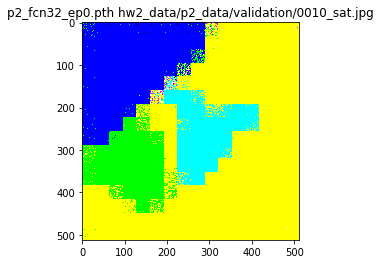

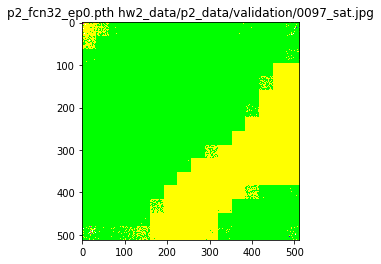

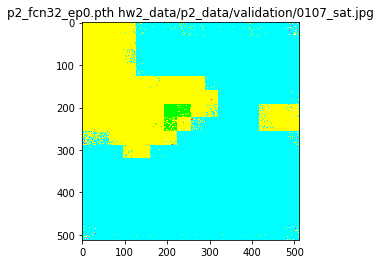

model loaded from p2_fcn32_ep5.pth


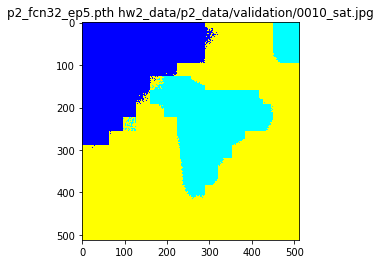

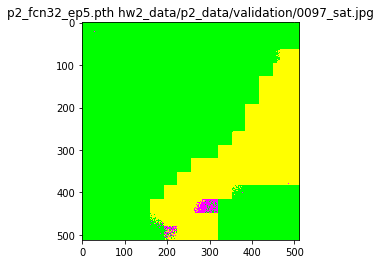

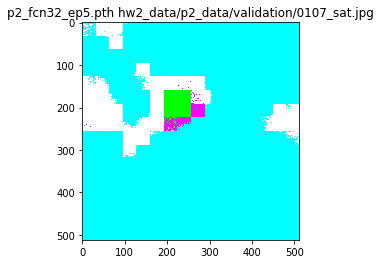

model loaded from p2_fcn32_ep10.pth


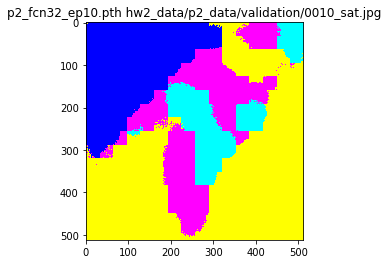

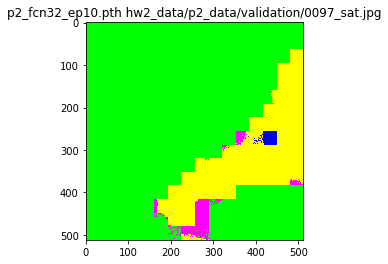

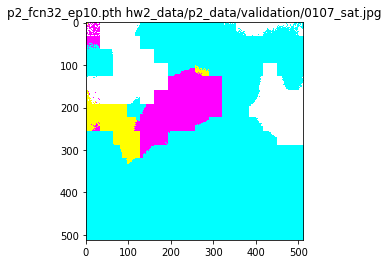

model loaded from p2_fcn32_ep15.pth


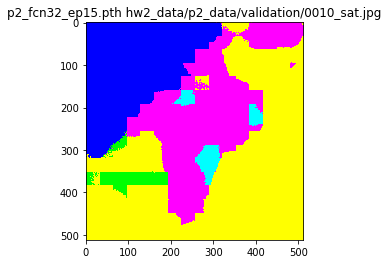

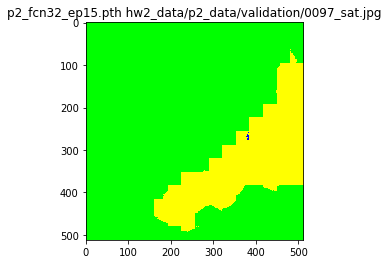

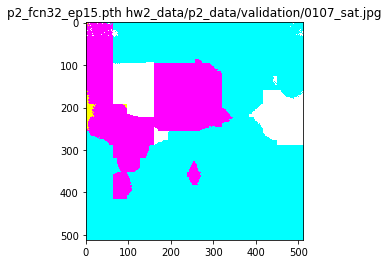

In [12]:
model = fcn32s(7)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 1e-3)
fnList = ['0010','0097','0107']
trans = transforms.ToTensor()
for i in range(4):
    fnModel = 'p2_fcn32_ep'+str(5*i)+'.pth'
    load_checkpoint(fnModel,model,optimizer)
    for j in range(3):
        model.eval()
        with torch.no_grad():
            fn = 'hw2_data/p2_data/validation/'+fnList[j]+'_sat.jpg'
            img = trans(Image.open(fn)).numpy()
            img = np.array([img])
            img = torch.from_numpy(img)
            img = img.to(device)
            output = model(img)
            pred = output.max(1, keepdim=True)[1]
            pred = encodeLabels(pred.cpu())
            fig, ax = plt.subplots()
            ax.imshow(pred, interpolation='nearest')
            ax.set_title(fnModel+' '+fn)
            plt.show() 

model loaded from p2_fcn16_ep0.pth


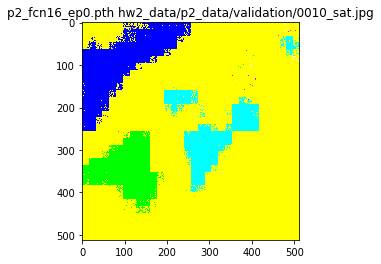

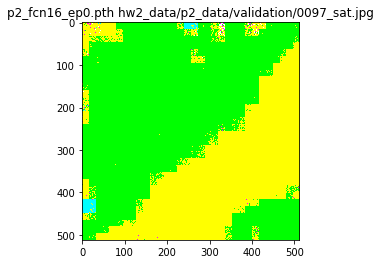

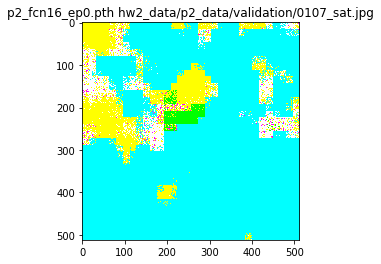

model loaded from p2_fcn16_ep5.pth


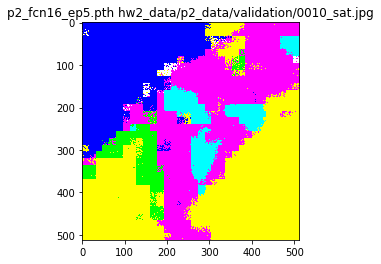

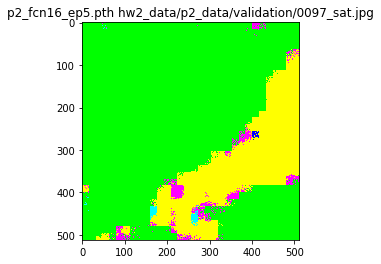

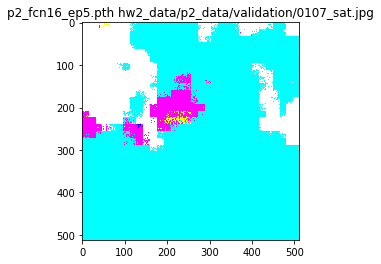

model loaded from p2_fcn16_ep10.pth


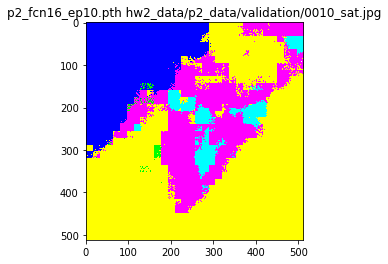

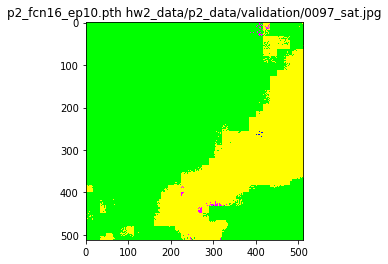

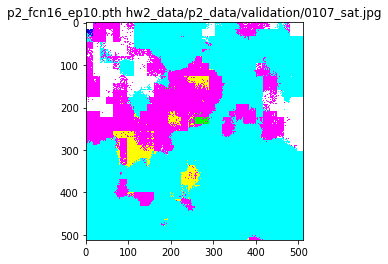

model loaded from p2_fcn16_ep15.pth


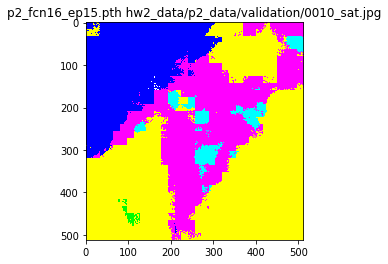

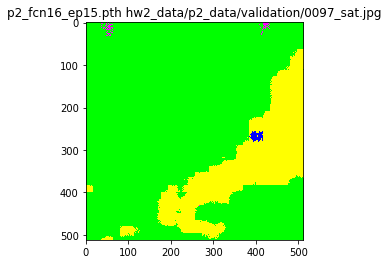

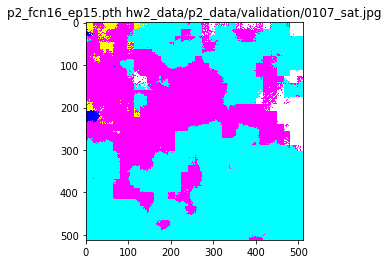

In [13]:
model = fcn16s(7)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 1e-3)
fnList = ['0010','0097','0107']
trans = transforms.ToTensor()
for i in range(4):
    fnModel = 'p2_fcn16_ep'+str(5*i)+'.pth'
    load_checkpoint(fnModel,model,optimizer)
    for j in range(3):
        model.eval()
        with torch.no_grad():
            fn = 'hw2_data/p2_data/validation/'+fnList[j]+'_sat.jpg'
            img = trans(Image.open(fn)).numpy()
            img = np.array([img])
            img = torch.from_numpy(img)
            img = img.to(device)
            output = model(img)
            pred = output.max(1, keepdim=True)[1]
            pred = encodeLabels(pred.cpu())
            fig, ax = plt.subplots()
            ax.imshow(pred, interpolation='nearest')
            ax.set_title(fnModel+' '+fn)
            plt.show() 